<!--  
title: Gas Output Modelling
author: Juan Guillermo  
description: End-to-end implementation of a predictive model for Mexico´s gas production.
It serves two core workflows: First, we perform correlation analysis with contemporaneus and
features which summarize the national context. Second, we follow a standard ML development 
process to train a predictive model over long forecast horizons. 
image_path:
-->

In [1]:
#
# Configuration
#

FORECAST_HORIZONS = [1,3,6,12]

with open(".env", "w") as f:

    f.write('TARGET_VAR="PRODUCCION NACIONAL (GAS MMPCD)"\n')
    f.write('TEST_RATIO="0.5"\n')
    f.write('BACK_SIGHT="24"\n')
    f.write('WINDOW_SIZE="48"\n')
    f.write(f'FORECAST_HORIZONS="{",".join(map(str, FORECAST_HORIZONS))}"\n')

print(".env file created successfully.")


.env file created successfully.


In [1]:
#
# load Configuration
#

import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
TARGET_VAR = os.getenv("TARGET_VAR")
TARGET_VAR

'PRODUCCION NACIONAL (GAS MMPCD)'

In [ ]:
%%writefile datasets.py
"""
title: Oil Production Dataset
description: Provides a data access layer to Mexico´s Gas Dataset, a comprehensive dataset about national
             gas production and several socioeconomical and industrial variables
"""
import os
import pandas as pd

def load_oil_production_data(folder="data", filename="BaseProduccion.xlsx"):
    """Loads and transforms oil production data from an Excel file."""
    file_path = os.path.join(folder, filename)
    
    print("Checking for production data file...")
    
    # Check if file exists
    if filename not in os.listdir(folder):
        raise FileNotFoundError(f"Error: '{filename}' not found in '{folder}' folder.")
    
    print("Production data file found. Loading data...")
    
    # Load production data
    prod_data = pd.read_excel(file_path)
    
    print("Production data successfully loaded.")
    print(f"Columns: {list(prod_data.columns)}")
    print(f"Shape: {prod_data.shape}")
    
    # Print before transformation (3 examples)
    print("Before transformation:")
    print(prod_data["FECHA"].head(3))
    
    print("Recasting time variable as a period variable...")
    # Convert to Period[M]
    prod_data["date"] = pd.to_datetime(prod_data["FECHA"], format="%Y-%m").dt.to_period("M")
    
    # Print after transformation (3 examples)
    print("\nAfter transformation:")
    print(prod_data[["FECHA", "date"]].head(3))
    
    # Sort by date
    prod_data = prod_data.sort_values(by="date")
    
    # Set date as index without dropping it
    prod_data = prod_data.set_index("date", drop=False)
    
    return prod_data


Overwriting datasets.py


In [4]:
from datasets import load_oil_production_data
prod_data=load_oil_production_data()
prod_data.info()

Checking for production data file...
Production data file found. Loading data...
Production data successfully loaded.
Columns: ['FECHA', 'PRODUCCION NACIONAL (GAS MMPCD)', 'Impotacion  (GAS MMPCD)', 'Demanda  (GAS MMPCD)', 'PRECIO (Dollars per MWh)', 'CONSUMO(terawatt-hours.)', '1P (MMpc)', '2P (MMpc)', '3P (MMpc)', 'Pozos', 'Sector_Petrolero (GAS MMPCD)', 'Sector_Industrial (GAS MMPCD)', 'Sectores_Residencial_Servicios_Autotransporte (GAS MMPCD)', 'Sector_Electrico (GAS MMPCD)', 'Poblacion']
Shape: (264, 15)
Before transformation:
0    2001-01
1    2001-02
2    2001-03
Name: FECHA, dtype: object
Recasting time variable as a period variable...

After transformation:
     FECHA     date
0  2001-01  2001-01
1  2001-02  2001-02
2  2001-03  2001-03
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 264 entries, 2001-01 to 2022-12
Freq: M
Data columns (total 16 columns):
 #   Column                                                     Non-Null Count  Dtype    
---  ------                    

In [5]:
%%writefile time_series_plots.py

"""
title: Time Series Plots
description: Provides graphical tools based on Matplotlib to visualize time series. 
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_time_series(
    data, time_col, value_col, sample_col=None, style="whitegrid"
):
    """
    Converts a time column to PeriodIndex, then to Timestamp, and plots the time series
    using a line plot. Optionally, segments the plot based on a sample column,
    changing colors for different samples and adding vertical dashed lines at sample boundaries.

    Parameters:
    - data (pd.DataFrame): Input DataFrame
    - time_col (str): Column name containing time information (YYYY-MM format)
    - value_col (str): Column name containing values to plot
    - sample_col (str, optional): Column name indicating different samples (segments)
    - style (str): Seaborn style for visualization (default: "whitegrid")
    """
    sns.set_theme(style=style)
    df = data.copy()

    # Convert time column to PeriodIndex and then to Timestamp
    df["date"] = pd.to_datetime(df[time_col], format="%Y-%m").dt.to_period("M")
    df.set_index("date", inplace=True)
    df.index = df.index.to_timestamp()

    plt.figure(figsize=(10, 5))

    if sample_col and sample_col in df.columns:
        unique_samples = df[sample_col].unique()
        palette = sns.color_palette("tab10", len(unique_samples))
        sample_colors = dict(zip(unique_samples, palette))

        previous_sample = None
        for sample in unique_samples:
            segment = df[df[sample_col] == sample]
            plt.plot(
                segment.index,
                segment[value_col],
                linestyle="-",
                #marker="o",
                color=sample_colors[sample],
                label=str(sample),
                alpha=0.85,
            )

            # Draw vertical line at the start of this segment (except the first one)
            if previous_sample is not None:
                boundary_date = segment.index.min()
                plt.axvline(boundary_date, color="gray", linestyle="--", linewidth=1.4, alpha=0.8)

            previous_sample = sample
    else:
        plt.plot(
            df.index,
            df[value_col],
            linestyle="-",
            color="b",
            linewidth=1.5,
            label=value_col,
            alpha=0.85,
        )

    plt.xlabel("Time (Months)")
    plt.ylabel(value_col)
    plt.title(f"Time Series Plot ({value_col} over {time_col})")
    plt.grid(True)
    plt.legend()
    plt.show()


#plot_time_series(prod_data, time_col="FECHA", value_col="PRODUCCION NACIONAL (GAS MMPCD)")

Overwriting time_series_plots.py


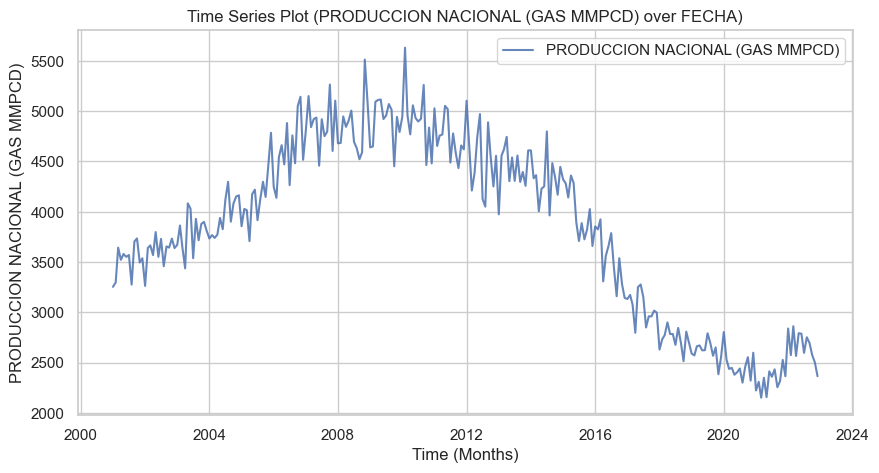

In [6]:
from time_series_plots import plot_time_series
plot_time_series(prod_data, time_col="FECHA", value_col="PRODUCCION NACIONAL (GAS MMPCD)")

In [7]:
%%writefile transformation_tools.py

"""
title: Transformation tools
description: Tools to facilitate feature transformation
"""

import pandas as pd
import numpy as np

def safe_transform(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms a dataframe by applying first differencing and standardization.
    - Fails fast if any feature is non-numeric.
    - Prints descriptive statistics before and after transformation.
    
    Args:
        df (pd.DataFrame): Dataframe containing numerical measurements.
    
    Returns:
        pd.DataFrame: Transformed dataframe in standardized first-difference space.
    """
    # 🚨 Fail fast if any column is non-numeric
    if not np.all(np.issubdtype(df[col].dtype, np.number) for col in df.columns):
        raise ValueError("All columns must be numeric for safe_transform to proceed.")
    
    print("\n📊 Before Transformation:")
    print(df.describe())

    # Compute first differences (ΔX = X_t - X_(t-1))
    df_diff = df.diff().dropna()  # Drop first row with NaNs
    
    # Standardization (Z-score normalization)
    df_standardized = (df_diff - df_diff.mean()) / df_diff.std()

    print("\n📈 After Transformation:")
    print(df_standardized.describe())

    return df_standardized

Overwriting transformation_tools.py


In [8]:
from transformation_tools import safe_transform 
import numpy as np

df=prod_data.copy()

# Select numerical columns (exclude categorical/date)
numerical_df = df.select_dtypes(include=[np.number])

# Apply safe transformation
df_transformed = safe_transform(numerical_df)
df_transformed


📊 Before Transformation:
       PRODUCCION NACIONAL (GAS MMPCD)  Impotacion  (GAS MMPCD)  \
count                       264.000000               264.000000   
mean                       3846.666341              2776.598235   
std                         883.844417              1971.323300   
min                        2152.263030               267.546199   
25%                        3062.557245              1080.282648   
50%                        3927.150440              1922.751970   
75%                        4605.913520              4897.245512   
max                        5631.446560              6435.033950   

       Demanda  (GAS MMPCD)  PRECIO (Dollars per MWh)  \
count            264.000000                264.000000   
mean            6506.576420                 15.432438   
std             1368.195656                  7.087175   
min             3442.426330                  4.612682   
25%             5450.330327                  9.918552   
50%             6571.707625 

,PRODUCCION NACIONAL (GAS MMPCD),Impotacion (GAS MMPCD),Demanda (GAS MMPCD),PRECIO (Dollars per MWh),CONSUMO(terawatt-hours.),1P (MMpc),2P (MMpc),3P (MMpc),Pozos,Sector_Petrolero (GAS MMPCD),Sector_Industrial (GAS MMPCD),Sectores_Residencial_Servicios_Autotransporte (GAS MMPCD),Sector_Electrico (GAS MMPCD),Poblacion
date,,,,,,,,,,,,,,
2001-02,0.163910,-0.467639,0.931673,-0.546423,-1.104338,-2.623910,-2.283984,-0.566529,-0.906091,0.888970,1.924997,1.518123,0.451729,-0.742792
2001-03,1.208019,0.052930,-0.465850,-0.150733,-0.315217,1.911407,-0.662303,-1.013257,0.158300,0.462473,-1.685049,-0.546415,-0.389684,0.250927
2001-04,-0.407344,0.008408,-0.250930,0.339473,-0.848691,-2.024750,0.556911,1.104209,0.615186,-1.681275,0.227577,-0.096928,0.203837,0.563914
2001-05,0.212408,-0.001745,0.152254,0.453758,0.831026,0.455445,-1.834407,-1.617270,0.244907,1.061105,-1.036903,0.654007,-0.092668,-0.659224
2001-06,-0.085042,-0.002501,-0.082043,-0.885122,0.068364,2.909719,0.357565,2.199932,-0.093993,-0.048988,-0.202202,-0.332464,-0.189756,-0.190173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08,0.548070,2.088314,0.922439,-0.549210,1.365940,-0.246843,-0.075634,-0.328512,-0.113688,0.258159,0.016317,0.014168,1.364579,-0.442186
2022-09,-0.185420,1.293321,-2.023882,1.173332,1.372732,0.745810,-0.022754,0.145995,-0.033786,-0.648128,-1.699621,-0.786465,-0.934133,0.886290
2022-10,-0.399691,-1.605531,-0.909014,-0.465941,-0.521789,-0.327671,-0.198505,-0.215629,0.357861,-0.456642,-0.262932,-1.061297,-0.485506,-1.077745


In [9]:
%%writefile correlation_analysis.py

"""
title: Correlation Analysis
description: 
"""


import pandas as pd

def correlation_analysis(df: pd.DataFrame, dependent: str, independent: list = None):
    """
    Computes Pearson correlation coefficients between a dependent variable and multiple independent variables.
    
    Args:
        df (pd.DataFrame): The input DataFrame containing numerical data.
        dependent (str): The name of the dependent variable.
        independent (list, optional): List of independent variable names. If None, use all numerical except dependent.

    Returns:
        dict: A dictionary where keys are independent variables and values are their correlation coefficients.
    """
    # Auto-select independent variables if not provided
    if independent is None:
        independent = [col for col in df.select_dtypes(include=[float, int]).columns if col != dependent]

    return {var: df[dependent].corr(df[var]) for var in independent}


Overwriting correlation_analysis.py


In [10]:
from correlation_analysis import correlation_analysis

# Run correlation analysis
correlations = correlation_analysis(df_transformed, dependent=TARGET_VAR)

# Print results
for var, coef in correlations.items():
    print(f"🔹 Correlation between oil_production and {var}: {coef:.4f}")

🔹 Correlation between oil_production and Impotacion  (GAS MMPCD): -0.0693
🔹 Correlation between oil_production and Demanda  (GAS MMPCD): 0.0106
🔹 Correlation between oil_production and PRECIO (Dollars per MWh): -0.0067
🔹 Correlation between oil_production and CONSUMO(terawatt-hours.): 0.1776
🔹 Correlation between oil_production and 1P (MMpc): -0.0806
🔹 Correlation between oil_production and 2P (MMpc): -0.0497
🔹 Correlation between oil_production and 3P (MMpc): 0.0019
🔹 Correlation between oil_production and Pozos: 0.0436
🔹 Correlation between oil_production and Sector_Petrolero (GAS MMPCD): -0.0203
🔹 Correlation between oil_production and Sector_Industrial (GAS MMPCD): 0.0378
🔹 Correlation between oil_production and Sectores_Residencial_Servicios_Autotransporte (GAS MMPCD): 0.0313
🔹 Correlation between oil_production and Sector_Electrico (GAS MMPCD): 0.0544
🔹 Correlation between oil_production and Poblacion: 0.1338


In [11]:
%%writefile feature_names_tools.py
"""
title: Feature Names Tools
description: Simplifies feature names.
"""
import pandas as pd

def rename_columns_for_us_audience(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rename DataFrame columns to be more understandable for an American audience,
    simplifying names and using underscores instead of spaces.
    """
    rename_map = {
        "FECHA": "date",
        "PRODUCCION NACIONAL (GAS MMPCD)": "national_production",
        "Impotacion  (GAS MMPCD)": "importation",
        "Demanda  (GAS MMPCD)": "demand",
        "PRECIO (Dollars per MWh)": "price",
        "CONSUMO(terawatt-hours.)": "consumption",
        "1P (MMpc)": "proven_reserves_1p",
        "2P (MMpc)": "probable_reserves_2p",
        "3P (MMpc)": "possible_reserves_3p",
        "Pozos": "wells",
        "Sector_Petrolero (GAS MMPCD)": "oil_sector",
        "Sector_Industrial (GAS MMPCD)": "industrial_sector",
        "Sectores_Residencial_Servicios_Autotransporte (GAS MMPCD)": "residential_services_transport",
        "Sector_Electrico (GAS MMPCD)": "electric_sector",
        "Poblacion": "population"
    }
    
    df_renamed = df.rename(columns=rename_map)
    return df_renamed

Overwriting feature_names_tools.py


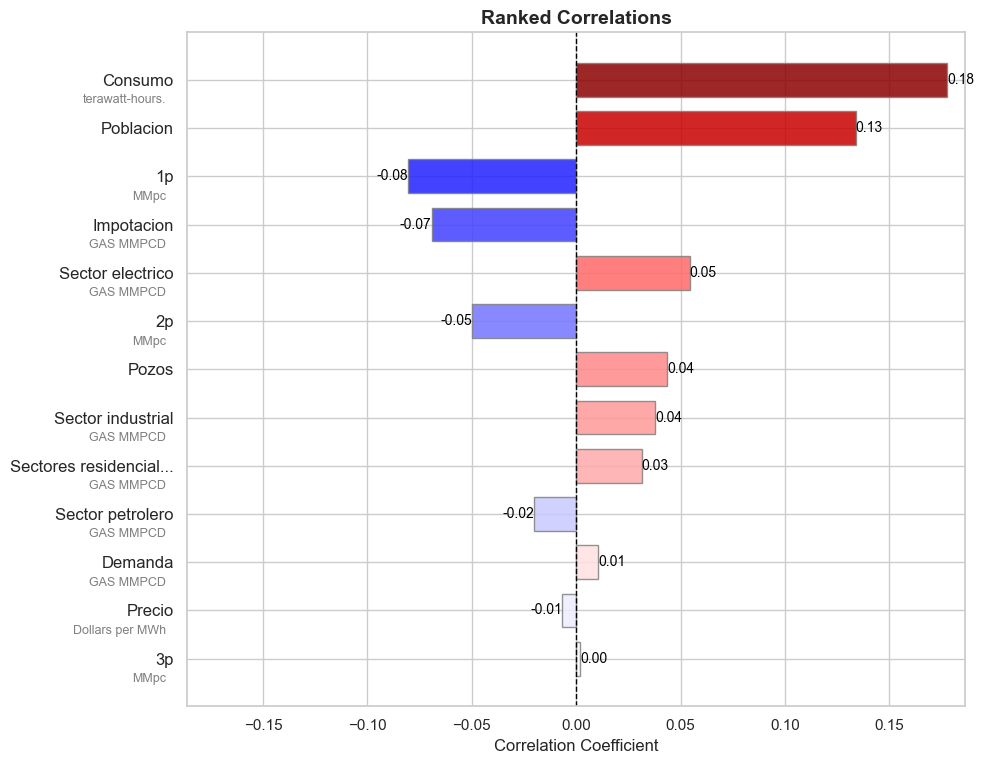

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib.pyplot as plt
import numpy as np


def wipe_out_scale_info(var_name):
    """Removes the measurement scale from the main variable name."""
    return re.sub(r"\s*\(.*?\)", "", var_name).strip()

def clean_variable_name(var_name, max_length=20):
    """
    Cleans variable names for plotting.
    - Removes underscores
    - Converts to lowercase and capitalizes only the first letter
    - Truncates if longer than max_length (adding '...')
    """
    clean_name = var_name.replace("_", " ").lower().capitalize()
    return clean_name[:max_length] + "..." if len(clean_name) > max_length else clean_name

def extract_scale(var_name):
    """Extracts the measurement scale from a variable name (if inside parentheses)."""
    match = re.search(r"\((.*?)\)", var_name)
    return match.group(1) if match else None

def format_variable_labels(variables, ax, x_offset=-0.01, include_scales=True):
    """
    Formats and places variable names and their scales on the given axis.
    Ensures main names are displayed with scale information positioned below.

    Args:
        variables (list): List of variable names.
        ax (matplotlib.axes.Axes): Axis object to apply labels.
        x_offset (float, optional): Offset for scale text placement. Defaults to -0.01.
    """
    formatted_labels = []
    scales = []

    for var in variables:
        main_name = clean_variable_name(wipe_out_scale_info(var))
        scale = extract_scale(var)
        formatted_labels.append(main_name)
        scales.append(scale if scale else "")

    ax.set_yticks(range(len(variables)))
    ax.set_yticklabels(formatted_labels, fontsize=12, ha="right")
    
    if include_scales:

        for i, scale in enumerate(scales):
            if scale:
                ax.text(ax.get_xlim()[0] + x_offset, i - 0.3, f"{scale}", 
                        fontsize=9, color="gray", ha="right", va="top")

import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_correlations(correlations, x_limit: float = None):
    """
    Plots a horizontal bar chart of ranked correlation coefficients using a continuous
    red-blue color scale to emphasize the direction and magnitude of correlation.

    Args:
        correlations (dict): Dictionary mapping variable names to correlation values.
        x_limit (float, optional): Custom limit for the x-axis. If None, auto-computed with a 5% margin.
    """
    # Sort correlations by absolute value
    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]))
    variables = [var for var, _ in sorted_correlations]
    values = [corr for _, corr in sorted_correlations]

    # Compute color and axis range based on max absolute value
    max_abs = max(abs(val) for val in values)
    margin = max_abs * 0.05
    color_range = (-max_abs - margin, max_abs + margin)
    
    if x_limit is None:
        x_limit = max_abs + margin

    # Normalize and map to continuous colormap
    norm = mpl.colors.Normalize(*color_range)
    cmap = plt.get_cmap("seismic")
    colors = [cmap(norm(val)) for val in values]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, len(variables) * 0.6))
    bars = ax.barh(range(len(variables)), values, color=colors, alpha=0.85, edgecolor="gray", height=0.7)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("Correlation Coefficient", fontsize=12)
    ax.set_title("Ranked Correlations", fontsize=14, weight="bold")
    ax.set_xlim(-x_limit, x_limit)

    format_variable_labels(variables, ax)

    for i, value in enumerate(values):
        position_y = bars[i].get_y() + bars[i].get_height() / 2
        alignment = "left" if value > 0 else "right"
        ax.text(value, position_y, f"{value:.2f}", va="center", ha=alignment, fontsize=10, color="black")

    plt.tight_layout()
    plt.show()


# Compute correlations
correlations = correlation_analysis(df_transformed, dependent=TARGET_VAR)

# Plot results
plot_correlations(correlations)

In [13]:
%%writefile time_series_utils.py

import pandas as pd

def lag_predictor_variables(df: pd.DataFrame, dependent: str, lag_orders: list):
    """
    Generates multiple lagged predictor datasets for different lag orders while keeping the original index
    and dependent variable unchanged.
    
    Parameters:
        df (pd.DataFrame): The input dataset with time-series data.
        dependent (str): The target variable (remains unchanged).
        lag_orders (list): A list of integers specifying the lag orders for predictors.
    
    Returns:
        list of pd.DataFrame: A list of DataFrames, each corresponding to a different lag order.
    """
    results = []
    
    for lag in lag_orders:
        df_lagged = df.copy()
        df_lagged[df.drop(columns=[dependent]).columns] = df.drop(columns=[dependent]).shift(lag)  # Shift predictors
        df_lagged = df_lagged.dropna()  # Drop NaN rows caused by shifting
        results.append(df_lagged)  # Append to the results list
    
    return results


Overwriting time_series_utils.py


In [14]:
import pandas as pd

def lag_predictor_variables(df: pd.DataFrame, dependent: str, lag_orders: list):
    """
    Efficiently generates multiple lagged predictor datasets for different lag orders.

    Parameters:
        df (pd.DataFrame): The input dataset with time-series data.
        dependent (str): The target variable to be shifted.
        lag_orders (list): A list of integers specifying the lag orders.

    Returns:
        list of pd.DataFrame: A list of DataFrames, each corresponding to a different lag order.
    """
    results = []
    
    for lag in lag_orders:
        df_lagged = df.copy()
        df_lagged[dependent] = df[dependent].shift(-lag)  # Shift dependent variable
        df_lagged = df_lagged.dropna()  # Remove NaN values caused by shifting
        results.append(df_lagged)

    return results


# Define the lag orders you want to generate
lag_orders = list(range(0, 13))  # Includes lag 0

# Generate lagged datasets
lagged_dfs = lag_predictor_variables(df_transformed, dependent=TARGET_VAR, lag_orders=lag_orders)


# Validation: Print the number of observations for each lagged DataFrame
for lag, df_lagged in zip(lag_orders, lagged_dfs):
    print(f"📌 Lag order = {lag} → Number of observations: {len(df_lagged)}")


📌 Lag order = 0 → Number of observations: 263
📌 Lag order = 1 → Number of observations: 262
📌 Lag order = 2 → Number of observations: 261
📌 Lag order = 3 → Number of observations: 260
📌 Lag order = 4 → Number of observations: 259
📌 Lag order = 5 → Number of observations: 258
📌 Lag order = 6 → Number of observations: 257
📌 Lag order = 7 → Number of observations: 256
📌 Lag order = 8 → Number of observations: 255
📌 Lag order = 9 → Number of observations: 254
📌 Lag order = 10 → Number of observations: 253
📌 Lag order = 11 → Number of observations: 252
📌 Lag order = 12 → Number of observations: 251


In [15]:
# Generate lagged datasets
lagged_dfs = lag_predictor_variables(df_transformed, dependent=TARGET_VAR, lag_orders=lag_orders)

# Collect correlation results
correlation_results = []

for lag, df_lagged in zip(lag_orders, lagged_dfs):
    correlations = correlation_analysis(df_lagged, dependent=TARGET_VAR)
    for predictor, correlation in correlations.items():
        correlation_results.append({"predictor": predictor, "correlation": correlation, "lag_order": lag})

# Convert to DataFrame
df_correlations = pd.DataFrame(correlation_results)

# Display preview
df_correlations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   predictor    169 non-null    object 
 1   correlation  169 non-null    float64
 2   lag_order    169 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.1+ KB


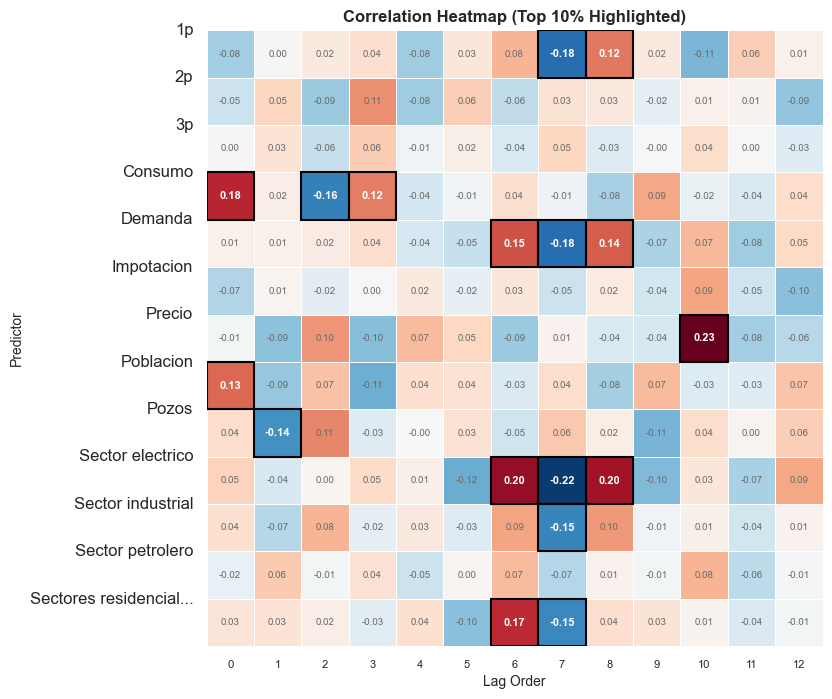

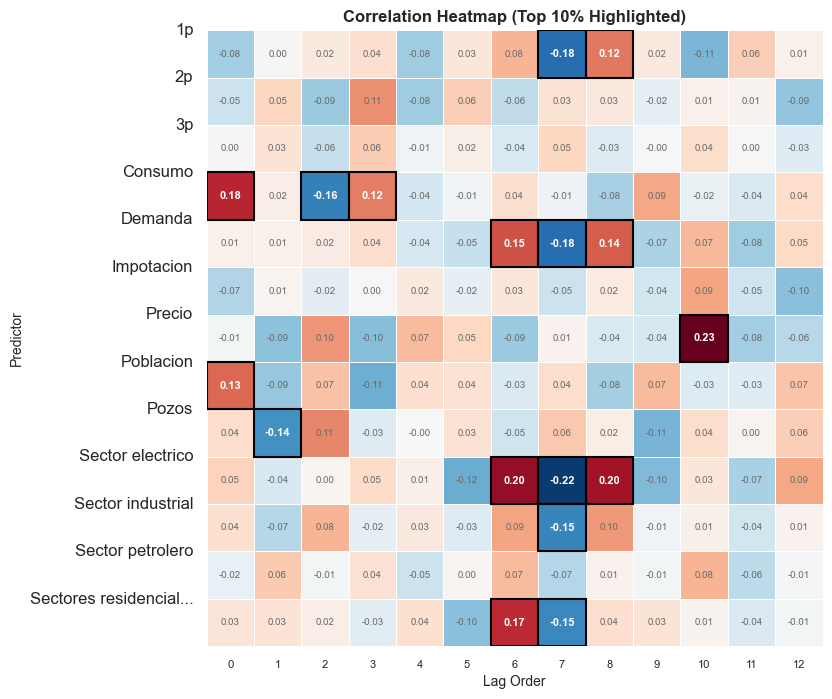

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation_heatmap(df_correlations, percentile_threshold=85):
    """
    Plots a heatmap of correlation values over different lag orders with enhanced highlighting.

    Enhancements:
    - High correlation values (above the given percentile threshold) are bold and larger.
    - Non-highlighted values use a dark gray color to blend smoothly.
    - Uses a dynamically determined threshold based on the given percentile.
    - Increases border width for highly correlated cells.
    - Forces square-shaped cells and removes the legend (color bar).
    - Formats predictor labels using `format_variable_labels`.

    Args:
        df_correlations (pd.DataFrame): DataFrame with 'predictor', 'correlation', and 'lag_order' columns.
        percentile_threshold (float, optional): Percentile threshold for highlighting. Default is 85.

    Returns:
        matplotlib.figure.Figure: The generated heatmap figure.
    """
    required_columns = {"predictor", "correlation", "lag_order"}
    if not required_columns.issubset(df_correlations.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df_correlations.columns)}")

    # Pivot data & handle missing values
    heatmap_data = df_correlations.pivot(index="predictor", columns="lag_order", values="correlation").fillna(0)

    # Compute threshold dynamically from the given percentile
    highlight_threshold = np.percentile(np.abs(heatmap_data.values), percentile_threshold)

    # Define vmin, vmax dynamically using the computed percentile
    vmin, vmax = -highlight_threshold, highlight_threshold  

    # Create figure with dynamic height, adjusting for square aspect ratio
    fig_size = max(8, len(heatmap_data) * 0.5)
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))

    # Generate heatmap with square-shaped cells
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        cmap="RdBu_r",
        center=0, 
        fmt=".2f",
        linewidths=0.4, 
        square=True,  # Forces square cells
        cbar=False,  # Removes color bar (legend)
        annot_kws={"size": 7},  # Increase base text size
        ax=ax
    )

    # Apply formatted labels to the y-axis
    format_variable_labels(heatmap_data.index.tolist(), ax, include_scales=False)

    # Adjust text styles dynamically
    for text, value in zip(ax.texts, heatmap_data.values.flatten()):
        if abs(value) >= highlight_threshold:
            text.set_fontsize(8)
            text.set_weight("bold")
            text.set_color("white")  # High correlations are bold and black
        else:
            text.set_fontsize(7)
            text.set_color("dimgray")  # Non-highlighted values are dark gray

    # Increase border width for highly correlated cells
    for i in range(heatmap_data.shape[0]):
        for j in range(heatmap_data.shape[1]):
            if abs(heatmap_data.iloc[i, j]) >= highlight_threshold:
                rect = plt.Rectangle(
                    (j, i), 1, 1, fill=False, edgecolor="black", linewidth=1.5
                )
                ax.add_patch(rect)

    # Labels & Formatting
    ax.set_xlabel("Lag Order", fontsize=10)
    ax.set_ylabel("Predictor", fontsize=10)
    ax.set_title(f"Correlation Heatmap (Top {100 - percentile_threshold}% Highlighted)", fontsize=12, weight="bold")
    ax.tick_params(axis="x", labelsize=8)

    plt.show()
    return fig

# Run the visualization on df_correlations
plot_correlation_heatmap(df_correlations, percentile_threshold=90)

In [17]:
#
# (0)
#
import os
from dotenv import load_dotenv
from datasets import load_oil_production_data
from feature_names_tools import rename_columns_for_us_audience

# Load environment variables
load_dotenv()
TARGET_VAR = os.getenv("TARGET_VAR")
TARGET_VAR

'PRODUCCION NACIONAL (GAS MMPCD)'

In [18]:
#
# (1)
# 
prod_data=load_oil_production_data()
prod_data.info()

Checking for production data file...
Production data file found. Loading data...
Production data successfully loaded.
Columns: ['FECHA', 'PRODUCCION NACIONAL (GAS MMPCD)', 'Impotacion  (GAS MMPCD)', 'Demanda  (GAS MMPCD)', 'PRECIO (Dollars per MWh)', 'CONSUMO(terawatt-hours.)', '1P (MMpc)', '2P (MMpc)', '3P (MMpc)', 'Pozos', 'Sector_Petrolero (GAS MMPCD)', 'Sector_Industrial (GAS MMPCD)', 'Sectores_Residencial_Servicios_Autotransporte (GAS MMPCD)', 'Sector_Electrico (GAS MMPCD)', 'Poblacion']
Shape: (264, 15)
Before transformation:
0    2001-01
1    2001-02
2    2001-03
Name: FECHA, dtype: object
Recasting time variable as a period variable...

After transformation:
     FECHA     date
0  2001-01  2001-01
1  2001-02  2001-02
2  2001-03  2001-03
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 264 entries, 2001-01 to 2022-12
Freq: M
Data columns (total 16 columns):
 #   Column                                                     Non-Null Count  Dtype    
---  ------                    

In [19]:
%%writefile debugging_tools.py
#
def replace_values_with_coordinates(df):
    """
    Replaces all values in the DataFrame with a string of the format {col_name}_{index_value}.

    Parameters:
    - df: DataFrame to tag.

    Returns:
    - A new DataFrame with tagged string values.
    """
    return df.apply(lambda col: [f"{col.name}_{i}" for i in df.index], axis=0)

Overwriting debugging_tools.py


In [20]:
#
# (2)
# 

from debugging_tools import replace_values_with_coordinates
#
toy_example=prod_data[['PRODUCCION NACIONAL (GAS MMPCD)', 'Impotacion  (GAS MMPCD)', 'Demanda  (GAS MMPCD)']]
toy_example=rename_columns_for_us_audience(toy_example)
toy_example= replace_values_with_coordinates(toy_example)
toy_example

,national_production,importation,demand
date,,,
2001-01,national_production_2001-01,importation_2001-01,demand_2001-01
2001-02,national_production_2001-02,importation_2001-02,demand_2001-02
2001-03,national_production_2001-03,importation_2001-03,demand_2001-03
2001-04,national_production_2001-04,importation_2001-04,demand_2001-04
2001-05,national_production_2001-05,importation_2001-05,demand_2001-05
...,...,...,...
2022-08,national_production_2022-08,importation_2022-08,demand_2022-08
2022-09,national_production_2022-09,importation_2022-09,demand_2022-09
2022-10,national_production_2022-10,importation_2022-10,demand_2022-10


In [21]:
%%writefile time_series_preprocessing.py

import pandas as pd
def add_lagged_features(df, target_var, back_sight=1):
    """
    Adds lagged features up to `back_sight` steps for all columns except the target variable.

    Parameters:
    - df (pd.DataFrame): Date-indexed dataframe with input features and a target variable.
    - target_var (str): Name of the column to use as the target variable.
    - back_sight (int): Number of lag periods to include as features.

    Returns:
    - pd.DataFrame: The dataframe with lagged features added (and NaNs dropped).
    - str: The name of the target variable.
    - int: The back_sight value.
    """
    df = df.copy()
    non_target_cols = [col for col in df.columns if col != target_var]

    for col in non_target_cols:
        for lag in range(1, back_sight + 1):
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)

    # Drop rows with any NaN values introduced by lagging
    df = df.dropna()

    return df

Overwriting time_series_preprocessing.py


In [22]:
#
# (3)
#
from time_series_preprocessing import add_lagged_features
toy_example_with_backsight=add_lagged_features(toy_example, target_var="national_production", back_sight=2)
toy_example_with_backsight.head(3)

,national_production,importation,demand,importation_lag_1,importation_lag_2,demand_lag_1,demand_lag_2
date,,,,,,,
2001-03,national_production_2001-03,importation_2001-03,demand_2001-03,importation_2001-02,importation_2001-01,demand_2001-02,demand_2001-01
2001-04,national_production_2001-04,importation_2001-04,demand_2001-04,importation_2001-03,importation_2001-02,demand_2001-03,demand_2001-02
2001-05,national_production_2001-05,importation_2001-05,demand_2001-05,importation_2001-04,importation_2001-03,demand_2001-04,demand_2001-03


In [23]:
%%writefile ml_samples.py

import os
from dotenv import load_dotenv
from datasets import load_oil_production_data
from time_series_utils import lag_predictor_variables  # Make sure to import this properly

# Load environment variables
load_dotenv()
TARGET_VAR = os.getenv("TARGET_VAR")
TEST_RATIO = float(os.getenv("TEST_RATIO"))

# Load the production dataset
prod_data = load_oil_production_data()

# Split index based on the TEST_RATIO
split_index = int(len(prod_data) * (1 - TEST_RATIO))
prod_data["sample"] = ["Train"] * split_index + ["Test"] * (len(prod_data) - split_index)

# Define train/test date index-only DataFrames
training_dates = prod_data[prod_data["sample"] == "Train"][[]]
test_dates = prod_data[prod_data["sample"] == "Test"][[]]

# Define target variable series for training and testing
train_y = prod_data.loc[training_dates.index, TARGET_VAR]
test_y = prod_data.loc[test_dates.index, TARGET_VAR]

# Quality check: Ensure no overlap
assert training_dates.index.max() < test_dates.index.min(), "Date ranges overlap!"

# Print summary
print(f"Training Data: {len(training_dates)} observations from {training_dates.index.min()} to {training_dates.index.max()}")
print(f"Test Data: {len(test_dates)} observations from {test_dates.index.min()} to {test_dates.index.max()}")


def prep_test_and_train(data, forecast_horizon, target_var):
    """
    Generates lagged data for forecasting and splits it into training and testing sets.
    
    Parameters:
    - data (pd.DataFrame): The input dataset containing production data.
    - forecast_horizon (int): The number of steps ahead to forecast.
    - target_var (str): The name of the target variable for forecasting.
    
    Returns:
    - tuple: (train_measurements, test_measurements)
    """
    # Generate lagged predictor variables
    transformed_data = lag_predictor_variables(
        data.copy(), 
        dependent=target_var, 
        lag_orders=[forecast_horizon]
    )[0]  # Only take the first item from the list

    # Use globally defined training and test dates
    train_measurements = training_dates.join(transformed_data, how="inner")
    test_measurements = test_dates.join(transformed_data, how="inner")
    
    return train_measurements, test_measurements

# Exportable variables
__all__ = [
    "TARGET_VAR",
    "TEST_RATIO",
    "training_dates",
    "test_dates",
    "train_y",
    "test_y",
    "prod_data",
    "prep_test_and_train"
]

Overwriting ml_samples.py


In [24]:
#
# (4)
#
from ml_samples import prep_test_and_train
train, test= prep_test_and_train(toy_example_with_backsight, forecast_horizon=6, target_var="national_production")
train.head(3)

Checking for production data file...


Production data file found. Loading data...
Production data successfully loaded.
Columns: ['FECHA', 'PRODUCCION NACIONAL (GAS MMPCD)', 'Impotacion  (GAS MMPCD)', 'Demanda  (GAS MMPCD)', 'PRECIO (Dollars per MWh)', 'CONSUMO(terawatt-hours.)', '1P (MMpc)', '2P (MMpc)', '3P (MMpc)', 'Pozos', 'Sector_Petrolero (GAS MMPCD)', 'Sector_Industrial (GAS MMPCD)', 'Sectores_Residencial_Servicios_Autotransporte (GAS MMPCD)', 'Sector_Electrico (GAS MMPCD)', 'Poblacion']
Shape: (264, 15)
Before transformation:
0    2001-01
1    2001-02
2    2001-03
Name: FECHA, dtype: object
Recasting time variable as a period variable...

After transformation:
     FECHA     date
0  2001-01  2001-01
1  2001-02  2001-02
2  2001-03  2001-03
Training Data: 132 observations from 2001-01 to 2011-12
Test Data: 132 observations from 2012-01 to 2022-12


,national_production,importation,demand,importation_lag_1,importation_lag_2,demand_lag_1,demand_lag_2
date,,,,,,,
2001-09,national_production_2001-09,importation_2001-03,demand_2001-03,importation_2001-02,importation_2001-01,demand_2001-02,demand_2001-01
2001-10,national_production_2001-10,importation_2001-04,demand_2001-04,importation_2001-03,importation_2001-02,demand_2001-03,demand_2001-02
2001-11,national_production_2001-11,importation_2001-05,demand_2001-05,importation_2001-04,importation_2001-03,demand_2001-04,demand_2001-03


In [25]:
train.tail(3)

,national_production,importation,demand,importation_lag_1,importation_lag_2,demand_lag_1,demand_lag_2
date,,,,,,,
2011-10,national_production_2011-10,importation_2011-04,demand_2011-04,importation_2011-03,importation_2011-02,demand_2011-03,demand_2011-02
2011-11,national_production_2011-11,importation_2011-05,demand_2011-05,importation_2011-04,importation_2011-03,demand_2011-04,demand_2011-03
2011-12,national_production_2011-12,importation_2011-06,demand_2011-06,importation_2011-05,importation_2011-04,demand_2011-05,demand_2011-04


In [26]:
test.head(3)

,national_production,importation,demand,importation_lag_1,importation_lag_2,demand_lag_1,demand_lag_2
date,,,,,,,
2012-01,national_production_2012-01,importation_2011-07,demand_2011-07,importation_2011-06,importation_2011-05,demand_2011-06,demand_2011-05
2012-02,national_production_2012-02,importation_2011-08,demand_2011-08,importation_2011-07,importation_2011-06,demand_2011-07,demand_2011-06
2012-03,national_production_2012-03,importation_2011-09,demand_2011-09,importation_2011-08,importation_2011-07,demand_2011-08,demand_2011-07


In [27]:
test.tail(3)

,national_production,importation,demand,importation_lag_1,importation_lag_2,demand_lag_1,demand_lag_2
date,,,,,,,
2022-10,national_production_2022-10,importation_2022-04,demand_2022-04,importation_2022-03,importation_2022-02,demand_2022-03,demand_2022-02
2022-11,national_production_2022-11,importation_2022-05,demand_2022-05,importation_2022-04,importation_2022-03,demand_2022-04,demand_2022-03
2022-12,national_production_2022-12,importation_2022-06,demand_2022-06,importation_2022-05,importation_2022-04,demand_2022-05,demand_2022-04


In [28]:
%reset -f

#
# (0)
#
import os
from dotenv import load_dotenv
from datasets import load_oil_production_data
from time_series_preprocessing import add_lagged_features
from ml_samples import prep_test_and_train, test_dates, test_y
from feature_names import rename_columns_for_us_audience
from debugging_tools import replace_values_with_coordinates

TARGET_VAR = os.getenv("TARGET_VAR")
TEST_RATIO = float(os.getenv("TEST_RATIO"))
BACK_SIGHT = int(os.getenv("BACK_SIGHT"))
WINDOW_SIZE= int(os.getenv("WINDOW_SIZE"))

# Parse the comma-separated string into a list of integers
FORECAST_HORIZONS = list(map(int, os.getenv("FORECAST_HORIZONS").split(",")))
FORECAST_HORIZONS

[1, 3, 6, 12]

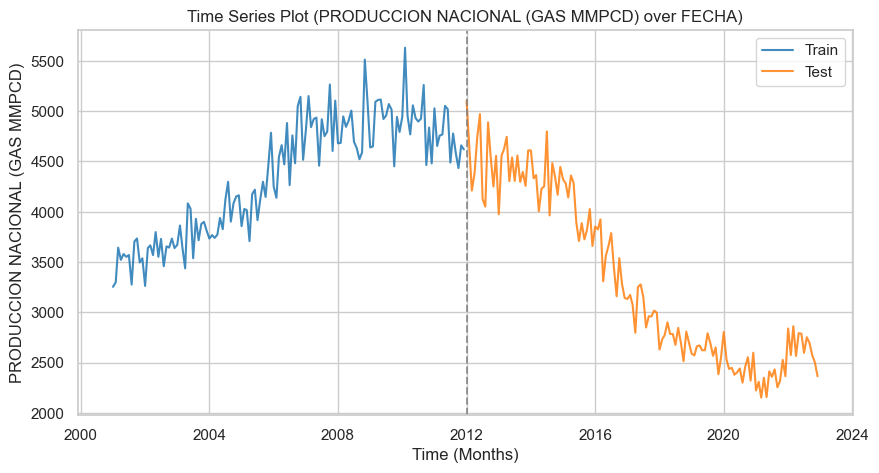

In [29]:
from time_series_plots import plot_time_series
from ml_samples import prod_data as prod_data_with_sample
plot_time_series(prod_data_with_sample, time_col="FECHA", value_col="PRODUCCION NACIONAL (GAS MMPCD)", sample_col="sample")

In [30]:
#
# (1)
# 
prod_data=load_oil_production_data()
prod_data.info()

#
# (2)
# 
oil_dataset=prod_data.select_dtypes("number")
oil_dataset=rename_columns_for_us_audience(oil_dataset)
#oil_dataset=replace_values_with_coordinates(oil_dataset)
oil_dataset["lagged_national_production"] = oil_dataset["national_production"].shift(1)
oil_dataset.head(3)

Checking for production data file...
Production data file found. Loading data...
Production data successfully loaded.
Columns: ['FECHA', 'PRODUCCION NACIONAL (GAS MMPCD)', 'Impotacion  (GAS MMPCD)', 'Demanda  (GAS MMPCD)', 'PRECIO (Dollars per MWh)', 'CONSUMO(terawatt-hours.)', '1P (MMpc)', '2P (MMpc)', '3P (MMpc)', 'Pozos', 'Sector_Petrolero (GAS MMPCD)', 'Sector_Industrial (GAS MMPCD)', 'Sectores_Residencial_Servicios_Autotransporte (GAS MMPCD)', 'Sector_Electrico (GAS MMPCD)', 'Poblacion']
Shape: (264, 15)
Before transformation:
0    2001-01
1    2001-02
2    2001-03
Name: FECHA, dtype: object
Recasting time variable as a period variable...

After transformation:
     FECHA     date
0  2001-01  2001-01
1  2001-02  2001-02
2  2001-03  2001-03
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 264 entries, 2001-01 to 2022-12
Freq: M
Data columns (total 16 columns):
 #   Column                                                     Non-Null Count  Dtype    
---  ------                    

,national_production,importation,demand,price,consumption,proven_reserves_1p,probable_reserves_2p,possible_reserves_3p,wells,oil_sector,industrial_sector,residential_services_transport,electric_sector,population,lagged_national_production
date,,,,,,,,,,,,,,,
2001-01,3253.97232,366.553370,3620.52569,15.566618,26494.953835,4.451727e+07,6.423757e+07,8.201045e+07,476.125062,1629.17046,1052.87700,66.560921,877.130729,100228659.0,NaN
2001-02,3297.92683,267.546199,4114.20242,14.383019,24216.445613,3.972185e+07,5.836044e+07,7.959358e+07,412.889187,1820.11540,1259.94074,84.283253,1057.002580,94187623.9,3253.97232
2001-03,3643.38907,303.688599,3895.42042,14.072857,23591.765624,4.299134e+07,5.653750e+07,7.542552e+07,422.799552,1919.85693,1081.30624,78.094493,932.031490,96404324.8,3297.92683


In [31]:
#
# (3)
#
oil_dataset_with_backsight=add_lagged_features(oil_dataset, target_var="national_production", back_sight=3)
oil_dataset_with_backsight.head(3)

,national_production,importation,demand,price,consumption,proven_reserves_1p,probable_reserves_2p,possible_reserves_3p,wells,oil_sector,...,residential_services_transport_lag_3,electric_sector_lag_1,electric_sector_lag_2,electric_sector_lag_3,population_lag_1,population_lag_2,population_lag_3,lagged_national_production_lag_1,lagged_national_production_lag_2,lagged_national_production_lag_3
date,,,,,,,,,,,,,,,,,,,,,
2001-05,3580.34182,350.220286,3882.53321,15.868940,23626.640493,3.994181e+07,5.300940e+07,7.302220e+07,479.969724,1788.92822,...,84.283253,1022.092430,932.03149,1057.00258,101221926.0,96404324.8,94187623.9,3643.38907,3297.92683,3253.97232
2001-06,3552.40632,371.971963,3859.41614,13.937705,23805.864747,4.498655e+07,5.373613e+07,8.144996e+07,472.542195,1779.29751,...,78.094493,1004.730120,1022.09243,932.03149,95875336.4,101221926.0,96404324.8,3522.38240,3643.38907,3297.92683
2001-07,3570.20148,396.981770,3442.42633,13.677558,24475.424499,4.039385e+07,5.952509e+07,7.442272e+07,416.493014,1586.59478,...,77.111601,952.192683,1004.73012,1022.09243,94426524.9,95875336.4,101221926.0,3580.34182,3522.38240,3643.38907


In [32]:
#
# (4)
#
train_test_dict = {}

for horizon in FORECAST_HORIZONS:
    train, test = prep_test_and_train(
        oil_dataset_with_backsight,
        forecast_horizon=horizon,
        target_var="national_production"
    )
    train_test_dict[horizon] = (train, test)

# Print dimensions and time ranges from the index
for horizon, (train, test) in train_test_dict.items():
    train_start, train_end = train.index.min(), train.index.max()
    test_start, test_end = test.index.min(), test.index.max()
    
    print(f"Horizon {horizon}:")
    print(f"  Train samples: {train.shape[0]}, features: {train.shape[1]}, range: {train_start} → {train_end}")
    print(f"  Test  samples: {test.shape[0]}, features: {test.shape[1]}, range: {test_start} → {test_end}")

Horizon 1:
  Train samples: 127, features: 57, range: 2001-06 → 2011-12
  Test  samples: 132, features: 57, range: 2012-01 → 2022-12
Horizon 3:
  Train samples: 125, features: 57, range: 2001-08 → 2011-12
  Test  samples: 132, features: 57, range: 2012-01 → 2022-12
Horizon 6:
  Train samples: 122, features: 57, range: 2001-11 → 2011-12
  Test  samples: 132, features: 57, range: 2012-01 → 2022-12
Horizon 12:
  Train samples: 116, features: 57, range: 2002-05 → 2011-12
  Test  samples: 132, features: 57, range: 2012-01 → 2022-12


In [33]:
%%writefile rf_model.py

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from typing import Optional, Tuple, List
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#
# (0)
#
DEFAULT_RF_PARAMS = {
    "n_estimators": 75,
    "max_depth": None,
    "min_samples_split": 5,
    "min_samples_leaf": 5,
    "n_jobs": -1
}

#
# (1)
#
def train_random_forest(train_df, target_var, hyperparams=None):
    """
    Trains a Random Forest regressor.

    Parameters:
    - train_df (pd.DataFrame): Training data including target variable.
    - target_var (str): Name of the target column.
    - hyperparams (dict): Optional dictionary overriding default hyperparameters.

    Returns:
    - model (RandomForestRegressor): Trained model.
    - features (list): List of feature column names used in training.
    """
    params = DEFAULT_RF_PARAMS.copy()
    if hyperparams:
        params.update(hyperparams)

    features = [col for col in train_df.columns if col != target_var]

    model = RandomForestRegressor(**params)
    model.fit(train_df[features], train_df[target_var])
    return model, features
#
# (2)
#
def evaluate_model(model, test_df, features, target_var):
    """
    Evaluates the model using RMSE and R².

    Returns:
    - dict: Contains RMSE, R², and predictions.
    """
    y_true = test_df[target_var]
    y_pred = model.predict(test_df[features])

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    return {
        "rmse": rmse,
        "r2": r2,
        "predictions": y_pred
    }
#
# (3)
#
def get_feature_importance(model, features):
    """
    Returns a pandas Series of feature importances.
    """
    return pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
#
# (4)
#
import pandas as pd
from typing import Optional
from sklearn.metrics import mean_squared_error, r2_score
#
def get_retraining_sample_from_datasets(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    prediction_index,
    window_size: int,
    forecast_horizon: int = 1
) -> pd.DataFrame:
    """
    Returns the retraining sample of `window_size` rows that *end*
    `forecast_horizon` steps before the prediction index, using the merged and sorted datasets.
    Ensures there's no data leakage via the target variable.
    
    Parameters:
    - train_df: Training dataframe.
    - test_df: Testing dataframe.
    - prediction_index: Index of the prediction target.
    - window_size: Number of rows in the training window.
    - forecast_horizon: Steps ahead being forecasted (default=1).
    
    Returns:
    - pd.DataFrame: Windowed training sample.
    """
    combined_df = pd.concat([train_df, test_df])
    combined_df = combined_df.sort_index()

    if prediction_index not in combined_df.index:
        raise ValueError(f"Prediction index {prediction_index} not found in combined data.")

    idx_loc = combined_df.index.get_loc(prediction_index)

    if isinstance(idx_loc, slice) or isinstance(idx_loc, list):
        raise ValueError("Prediction index must refer to a single row.")

    end_idx = idx_loc - forecast_horizon
    if end_idx < 0:
        raise ValueError("Not enough data before prediction index to account for forecast horizon.")

    start_idx = max(0, end_idx - window_size)
    return combined_df.iloc[start_idx:end_idx]
#
def evaluate_model_over_sliding_window(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_var: str,
    forecast_horizon: int,
    window_size: int = 36,
    hyperparams: Optional[dict] = None
) -> dict:
    """
    Evaluates a Random Forest model using a sliding window retraining scheme based on row count,
    avoiding data leakage by adjusting for forecast horizon.

    Parameters:
    - train_df: DataFrame with training data (must include target_var).
    - test_df: DataFrame with testing data (must include target_var).
    - target_var: Name of the target column.
    - window_size: Number of rows (months) in the sliding window (default=36).
    - forecast_horizon: Number of steps ahead being forecasted (default=1).
    - hyperparams: Optional Random Forest hyperparameters.

    Returns:
    - dict: Contains RMSE, R², and full prediction series.
    """
    predictions = []
    y_trues = []
    prediction_dates = []

    combined_df = pd.concat([train_df, test_df])
    combined_df = combined_df.sort_index()

    for prediction_index in test_df.index:
        # Retrieve training window excluding forecast_horizon
        try:
            train_window = get_retraining_sample_from_datasets(
                train_df=train_df,
                test_df=test_df,
                prediction_index=prediction_index,
                window_size=window_size,
                forecast_horizon=forecast_horizon
            )
        except ValueError:
            continue  # Skip if not enough data

        if len(train_window) < window_size:
            continue  # Not enough history to train

        # Train model
        model, features = train_random_forest(train_window, target_var, hyperparams)

        # Extract test point and predict
        test_point = combined_df.loc[[prediction_index]]
        X_test = test_point[features]
        y_pred = model.predict(X_test)[0]
        y_true = test_point[target_var].values[0]

        # Store results
        predictions.append(y_pred)
        y_trues.append(y_true)
        prediction_dates.append(prediction_index)

    y_true_series = pd.Series(y_trues, index=prediction_dates)
    y_pred_series = pd.Series(predictions, index=prediction_dates)

    rmse = mean_squared_error(y_true_series, y_pred_series, squared=False)
    r2 = r2_score(y_true_series, y_pred_series)

    return {
        "rmse": rmse,
        "r2": r2,
        "predictions": y_pred_series
    }

Overwriting rf_model.py


In [34]:
"""
train, test=train_test_dict[24]
test.index[0]
from rf_model import get_retraining_sample_from_datasets
df=get_retraining_sample_from_datasets(
   train,
   test,
   '2012-01',
   WINDOW_SIZE,
   24
)
df.loc[df.index.max()]
"""

"\ntrain, test=train_test_dict[24]\ntest.index[0]\nfrom rf_model import get_retraining_sample_from_datasets\ndf=get_retraining_sample_from_datasets(\n   train,\n   test,\n   '2012-01',\n   WINDOW_SIZE,\n   24\n)\ndf.loc[df.index.max()]\n"

In [35]:
#
# (5)
#

from rf_model import train_random_forest, evaluate_model
import pandas as pd

evaluation_results = []

for horizon, (train_df, test_df) in train_test_dict.items():
    model, features = train_random_forest(train_df, target_var="national_production")
    metrics = evaluate_model(model, test_df, features, target_var="national_production")

    evaluation_results.append({
        "horizon": horizon,
        "rmse": metrics["rmse"],
        "r2": metrics["r2"],
        "n_train": train_df.shape[0],
        "n_test": test_df.shape[0],
        "predictions": metrics["predictions"]  # kept in list, excluded in df
    })

# Convert to DataFrame excluding predictions
results_df = pd.DataFrame([
    {k: v for k, v in d.items() if k != "predictions"}
    for d in evaluation_results
])

results_df


,horizon,rmse,r2,n_train,n_test
0,1,1472.191193,-2.078703,127,132
1,3,1332.971505,-1.523952,125,132
2,6,1708.045097,-3.144175,122,132
3,12,1574.905667,-2.523291,116,132


In [36]:
%%writefile forecast_plots.py -a

import math
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_forecasts(test_dates_df, y_test, evaluation_results):
    """
    Creates one subplot per forecast horizon, showing actual vs. predicted values.

    Parameters:
    - test_dates_df (pd.DataFrame): Index-only DataFrame with a PeriodIndex (monthly).
    - y_test (array-like): True values to compare against predictions (same order as index).
    - evaluation_results (list of dicts): Each dict must include:
        - 'horizon': forecast horizon in months,
        - 'predictions': array-like, same length as y_test,
        - optionally 'r2': R-squared value of the predictions.
    """
    if not isinstance(test_dates_df.index, pd.PeriodIndex):
        raise ValueError("`test_dates_df` must have a PeriodIndex with monthly frequency.")

    test_index = test_dates_df.index.to_timestamp()
    y_test = np.array(y_test)

    n_plots = len(evaluation_results)
    n_cols = 2
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=True)
    axes = axes.flatten()

    plotted = 0

    for result in evaluation_results:
        horizon = result.get("horizon")
        preds = np.array(result.get("predictions"))

        if len(preds) != len(test_index):
            warnings.warn(f"Horizon {horizon}: Prediction length mismatch. Skipping.")
            continue

        r2 = result.get("r2", None)
        title = f"Forecast Horizon: {horizon} months"
        if r2 is not None:
            title += f" (R² = {r2:.2f})"

        ax = axes[plotted]
        ax.plot(test_index, y_test, label="Actual", color="tab:gray", linestyle="--")
        ax.plot(test_index, preds, label="Prediction", color="tab:blue", linewidth=2)

        ax.set_title(title)
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)

        plotted += 1

    # Hide unused subplots
    for j in range(plotted, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


Appending to forecast_plots.py


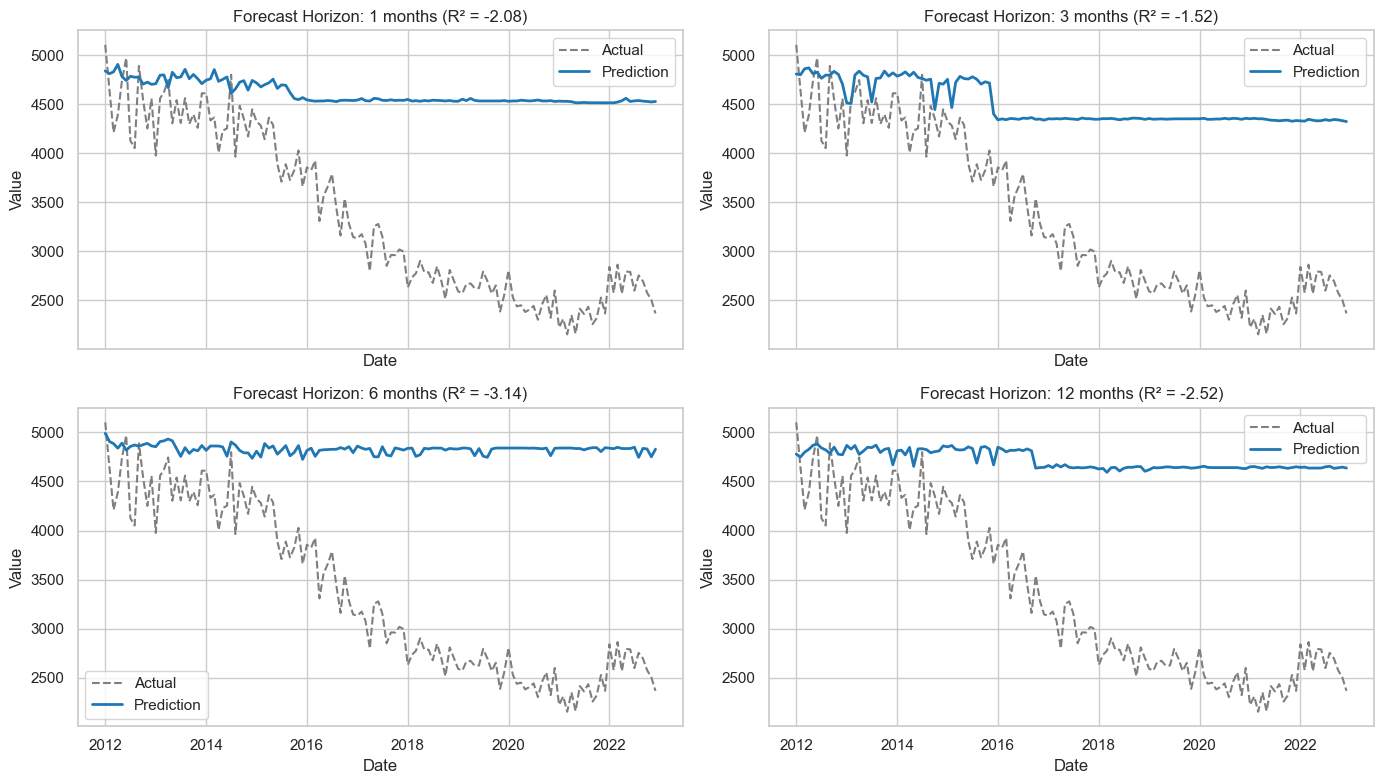

In [37]:
#
# (6)
#
from forecast_plots import plot_forecasts
plot_forecasts(test_dates, test_y.values, evaluation_results)


In [38]:
#
# (7)
#

from rf_model import  evaluate_model_over_sliding_window
import pandas as pd

evaluation_results = []

for horizon, (train_df, test_df) in train_test_dict.items():
    metrics = evaluate_model_over_sliding_window(
        train_df,
        test_df,
        forecast_horizon=horizon,
        target_var="national_production",
        window_size=WINDOW_SIZE
    )

    evaluation_results.append({
        "horizon": horizon,
        "rmse": metrics["rmse"],
        "r2": metrics["r2"],
        "n_train": train_df.shape[0],
        "n_test": test_df.shape[0],
        "predictions": metrics["predictions"]  # kept in list, excluded in df
    })

# Convert to DataFrame excluding predictions
results_df = pd.DataFrame([
    {k: v for k, v in d.items() if k != "predictions"}
    for d in evaluation_results
])

In [39]:
results_df

,horizon,rmse,r2,n_train,n_test
0,1,274.684112,0.892822,127,132
1,3,309.513718,0.863918,125,132
2,6,359.712204,0.816198,122,132
3,12,456.880631,0.703486,116,132


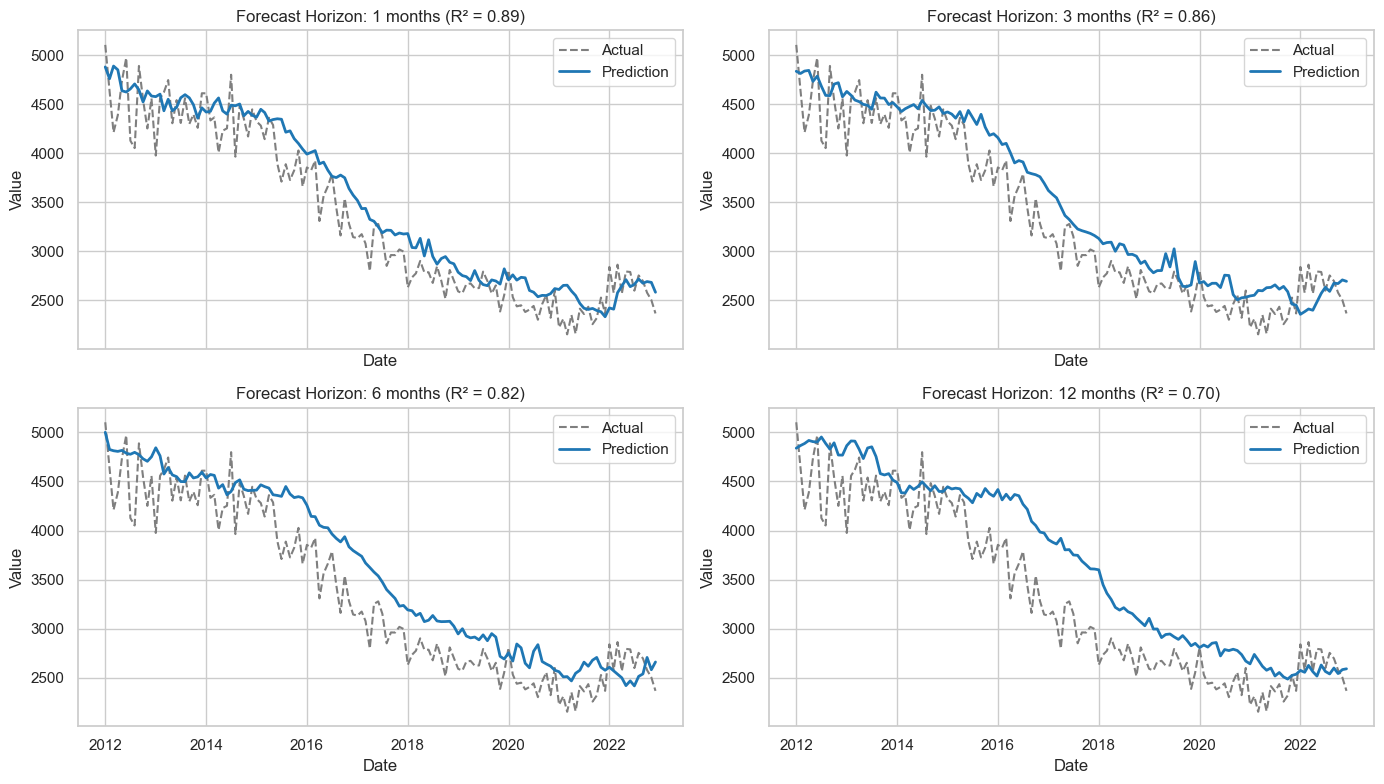

In [40]:
plot_forecasts(test_dates, test_y.values, evaluation_results)